In this notebook we will extract identified objects from the YOLO model's predictions, and apply different super-resolution techniques to make the objects look sharper.

# Load test images from combined HRSID/SADD dataset, get YOLO predictions and extract objects boxes:

In [2]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [3]:
# Modify as necessary
root_dir = r"/Users/alexm/Senior-Design"

In [4]:
# Paths to test images and labels
combined_datasets_dir = os.path.join(root_dir, "datasets", "HRSID_SADD_Combined")
combined_datasets_test_images_dir = os.path.join(combined_datasets_dir, "test", "images")
combined_datasets_test_labels_dir = os.path.join(combined_datasets_dir, "test", "labels")

In [5]:
# Load trained model
model_path = os.path.join(root_dir, "runs", "detect", "hrsid_sadd_combined_detection7", "weights", "best.pt")
model = YOLO(model_path)

In [6]:
# Load test images until we get 16 which have identified objects
test_image_names = os.listdir(combined_datasets_test_images_dir)
objects = []
idx = 0
while len(objects) < 16 and idx < len(test_image_names):
    image_path = os.path.join(combined_datasets_test_images_dir, test_image_names[idx])
    pred = model([image_path])
    # Check if any predictions were made
    if pred[0].boxes.conf.shape[0] > 0:
        objects.append(pred)
    idx += 1


0: 224x224 (no detections), 29.3ms
Speed: 0.4ms preprocess, 29.3ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 25.8ms
Speed: 0.3ms preprocess, 25.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 ship, 26.7ms
Speed: 0.2ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 25.9ms
Speed: 0.3ms preprocess, 25.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 26.1ms
Speed: 0.2ms preprocess, 26.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 27.3ms
Speed: 0.2ms preprocess, 27.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 ship, 26.3ms
Speed: 0.2ms preprocess, 26.3ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 27.5ms
Speed: 0.2ms preprocess, 27.5ms inference, 0.1ms po

In [7]:
# Function to convert xywh (centered at (x,y)) to coords that we can plot in plt
def xywh_to_corner_box_coords(x, y, w, h):
    lower_left_x = x - w / 2
    lower_left_y = y - h / 2
    return lower_left_x, lower_left_y

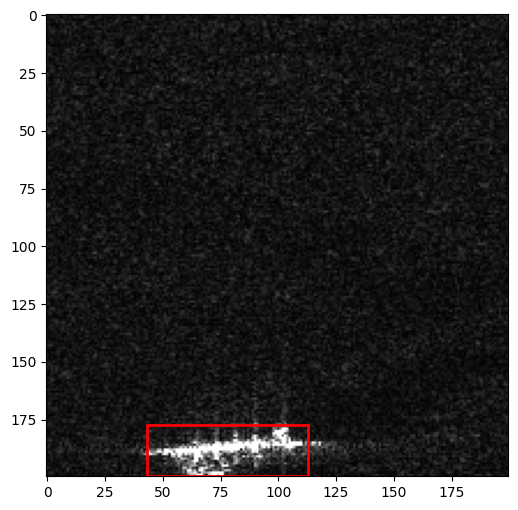

In [8]:
# Plot first image with bounding box drawn over identified object
fig, ax = plt.subplots(figsize=(6,6))

img_idx = 0
sample_obj = objects[img_idx][0]
sample_obj_img = sample_obj.orig_img
sample_obj_box_xywh = sample_obj.boxes.xywh[0]

ax.imshow(sample_obj_img)

width = sample_obj_box_xywh[2]
height = sample_obj_box_xywh[3]
corner_x, corner_y = xywh_to_corner_box_coords(sample_obj_box_xywh[0], sample_obj_box_xywh[1], width, height)
rect = patches.Rectangle((corner_x, corner_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

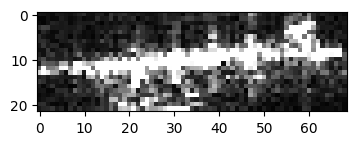

In [9]:
# Plot just identified object from first image (sized up by whatever matplotlib uses for interpolation)
fig, ax = plt.subplots(figsize=(4,4))

sample_obj_identified = sample_obj_img[int(corner_y):int(corner_y+height), int(corner_x):int(corner_x+width)]
ax.imshow(sample_obj_identified)
plt.show()

In [10]:
low_res_obj_patches_path = os.path.join(root_dir, "sr_testing", "low_res_obj_patches")
low_res_images_path = os.path.join(root_dir, "sr_testing", "low_res_images")

In [11]:
# Save all low-res images in a new folder
for img_idx in range(len(objects)):
    # Save every identified object patch
    for obj_idx in range(objects[img_idx][0].boxes.cls.shape[0]):

        obj_box_xywh = objects[img_idx][0].boxes.xywh[obj_idx]
        width = obj_box_xywh[2]
        height = obj_box_xywh[3]
        corner_x, corner_y = xywh_to_corner_box_coords(obj_box_xywh[0], obj_box_xywh[1], width, height)
        obj_patch = objects[img_idx][0].orig_img[int(corner_y):int(corner_y+height), int(corner_x):int(corner_x+width)]

        obj_patch_img = Image.fromarray(obj_patch)
        obj_save_path = os.path.join(low_res_obj_patches_path, "img_idx" + str(img_idx) + "obj_idx" + str(obj_idx) + ".png")
        obj_patch_img.save(obj_save_path)

    full_img = Image.fromarray(objects[img_idx][0].orig_img)
    full_img_save_path = os.path.join(low_res_images_path, "img_idx" + str(img_idx) + ".png")
    full_img.save(full_img_save_path)

## Apply pre-trained SwinIR, ESRGAN

In [12]:
import subprocess
import re
import shutil

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64"],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing 6 img_idx

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64",
     "--large_model"],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing 6 img

Note: The below code uses the basicsr package for some image processing, which is not immediately compatible with more recent PyTorch versions. If an error like "/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/basicsr/data/degradations.py", line 8, in <module>
    ```from torchvision.transforms.functional_tensor import rgb_to_grayscale```
ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'
is thrown, then change the line to ```from torchvision.transforms.functional import rgb_to_grayscale```


In [13]:
# Apply ESRGAN to full images
esrgan_path = os.path.join(root_dir, "super_resolution_testing", "Real-ESRGAN")
esrgan_model_path = os.path.join(root_dir, "sr_models", "RealESRGAN_x4plus.pth")
result = subprocess.run(
    ['python', os.path.join(esrgan_path, "inference_realesrgan.py"), 
     "-n", "RealESRGAN_x4plus",
     "--input", low_res_images_path,
     "-s", "4", "--fp32",
     "--output", os.path.join(root_dir, "super_resolution_testing", "results", "esrgan")],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)



Testing 0 img_idx0
Testing 1 img_idx1
Testing 2 img_idx10
Testing 3 img_idx11
Testing 4 img_idx12
Testing 5 img_idx13
Testing 6 img_idx14
Testing 7 img_idx15
Testing 8 img_idx2
Testing 9 img_idx3
Testing 10 img_idx4
Testing 11 img_idx5
Testing 12 img_idx6
Testing 13 img_idx7
Testing 14 img_idx8
Testing 15 img_idx9



### Visualize results from different models for a few images

In [6]:
import matplotlib.image as mpimg

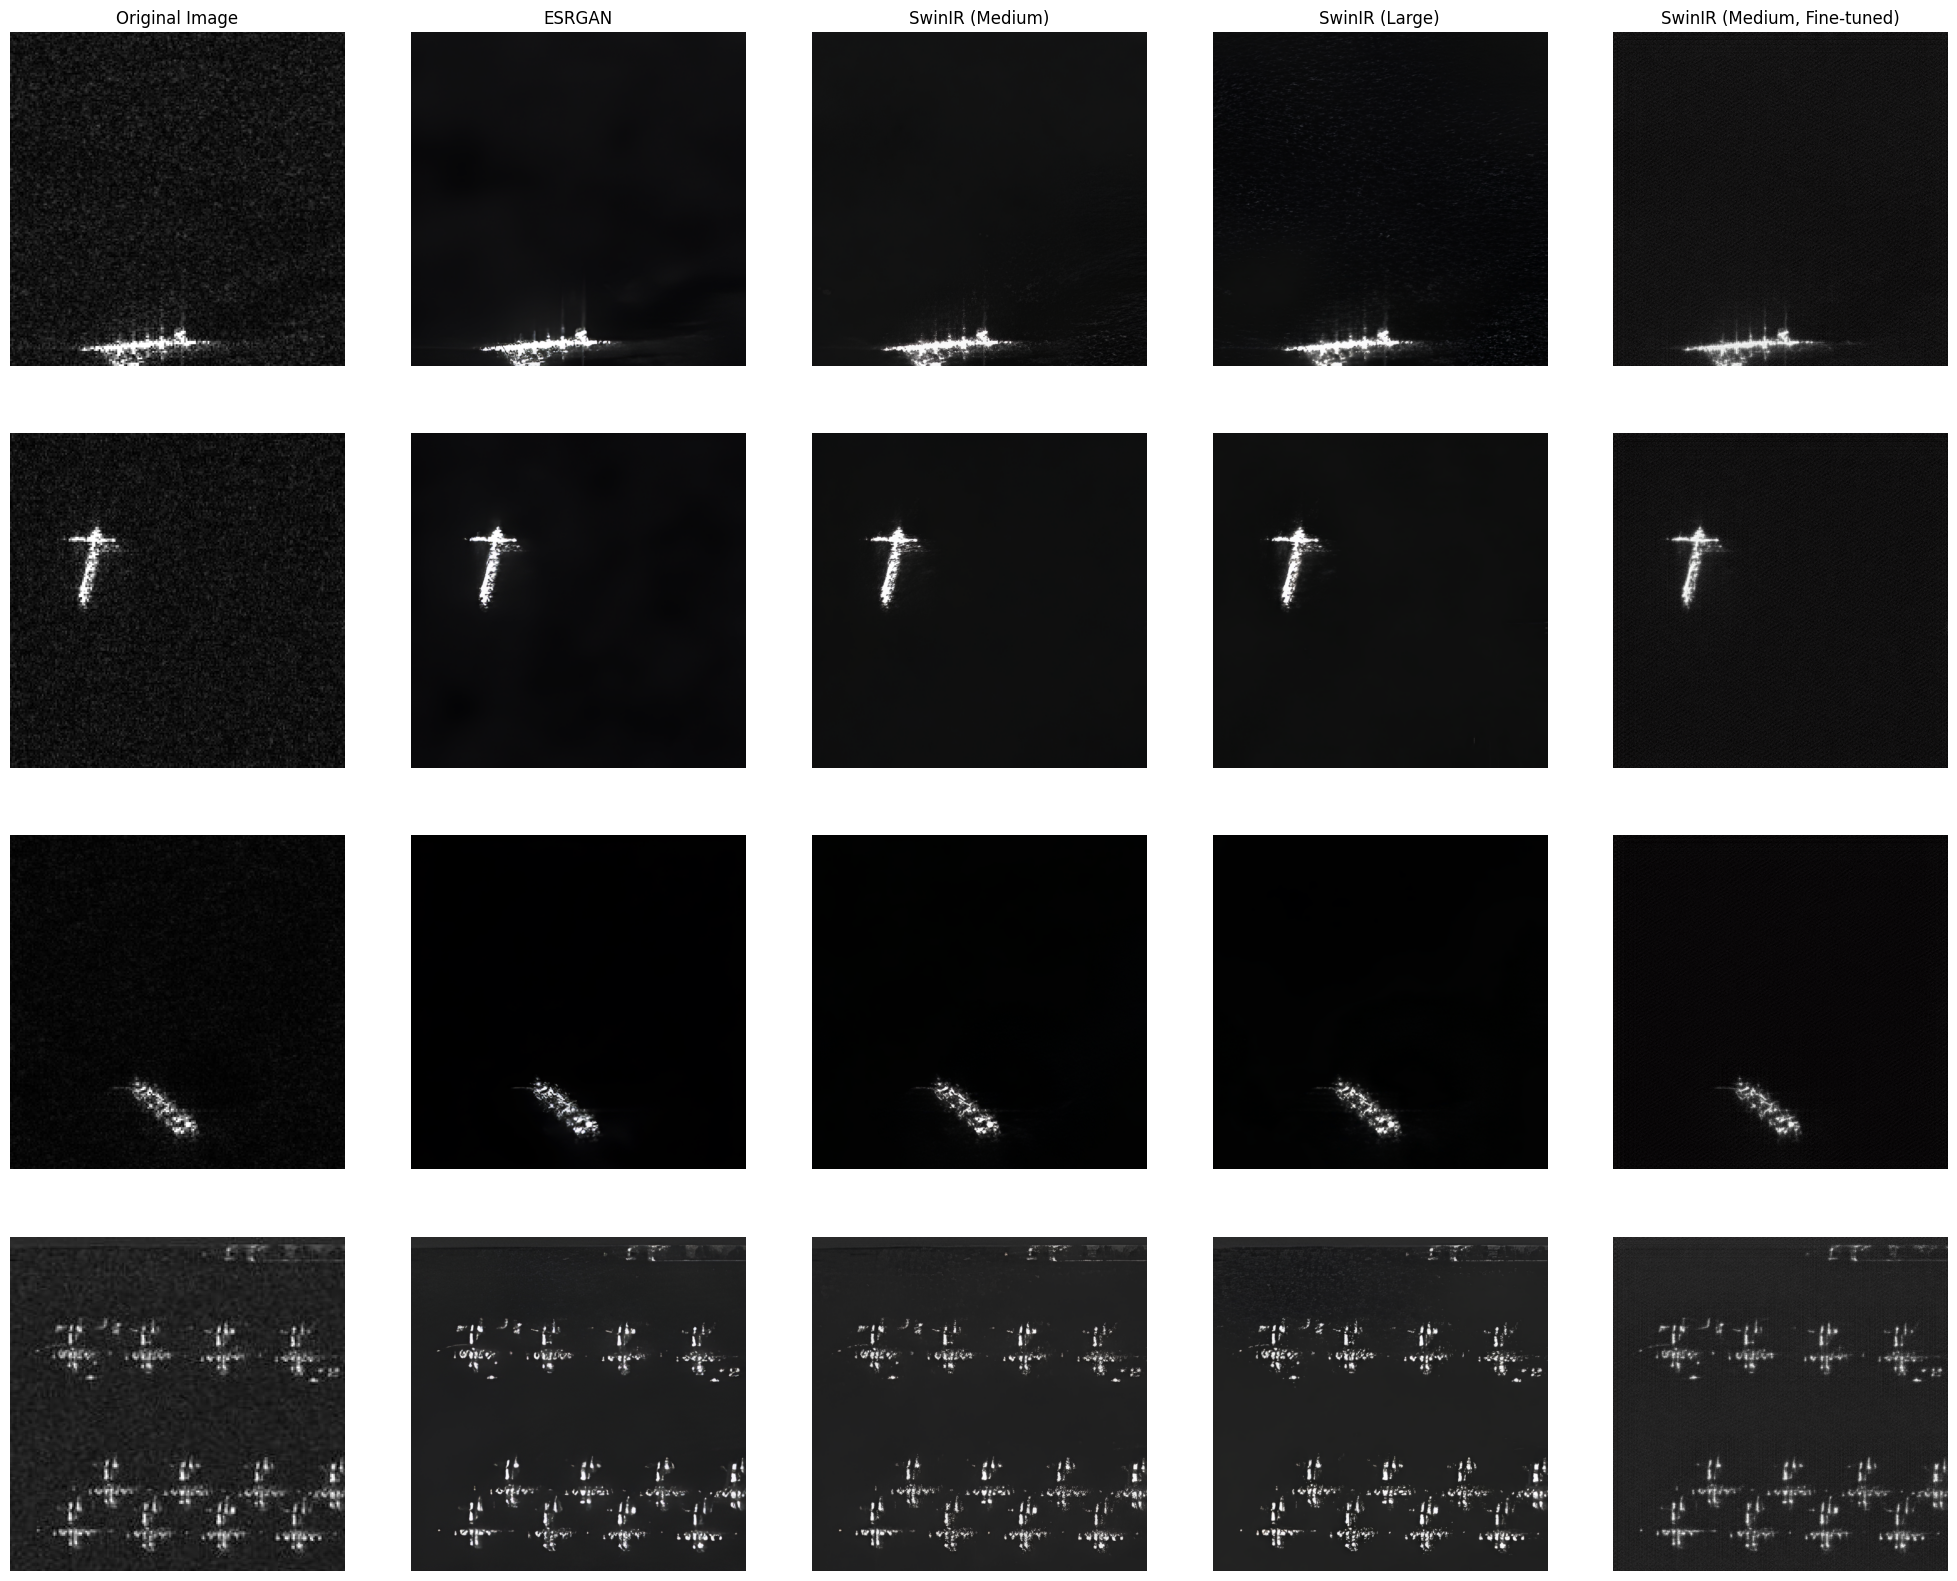

In [13]:
original_img_dir = os.path.join(root_dir, "sr_testing", "low_res_images")
results_dir = os.path.join(root_dir, "sr_testing", "results")

img_idxs = ["0", "2", "4", "15"]
num_cols = 5
num_images = len(img_idxs)

fig, axs = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(25,20))
axs[0, 0].axis("off")
axs[0, 0].set_title("Original Image")
col_titles = ["Original Image", "ESRGAN", "SwinIR (Medium)", "SwinIR (Large)", "SwinIR (Medium, Fine-tuned)"]
for col, title in zip(range(num_cols), col_titles):
    axs[0, col].set_title(title)
    for row, img_idx in enumerate(img_idxs):
        axs[row, col].axis("off")
        if col == 0:
            original_img_path = os.path.join(original_img_dir, "img_idx" + img_idx + ".png")
            im = mpimg.imread(original_img_path)
            axs[row, col].imshow(im)
        elif col == 1:
            esrgan_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "esrgan", "img_idx" + img_idx + "_out.png")
            im = mpimg.imread(esrgan_img_path)
            axs[row, col].imshow(im)
        elif col == 2:
            #swin_ir_medium_img_path = os.path.join(results_dir, "swin_ir_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            swin_ir_medium_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_real_sr_x4", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_img_path)
            axs[row, col].imshow(im)
        elif col == 3:
            swin_ir_large_img_path = os.path.join(results_dir, "swin_ir_large_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_large_img_path)
            axs[row, col].imshow(im)
        elif col == 4:
            swin_ir_medium_finetuned_img_path = os.path.join(results_dir,  "swin_ir_x4_finetuned", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_finetuned_img_path)
            axs[row, col].imshow(im)

plt.axis('off')
plt.show()

## View results from fine-tuned model

In [50]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script instead
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN_finetuned.pth")
save_path = os.path.join(root_dir, "super_resolution_testing", "results", "swinir_x4_finetuned")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64",
     "--save_dir", save_path],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN_finetuned.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects using finetuned model, use KAIR testing script instead
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "1500_G.pth")
save_path = os.path.join(root_dir, "super_resolution_testing", "results", "swinir_x4_finetuned_extra")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64",
     "--save_dir", save_path],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/1500_G.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing 6 img_idx14           
Testing 7 img_idx15    

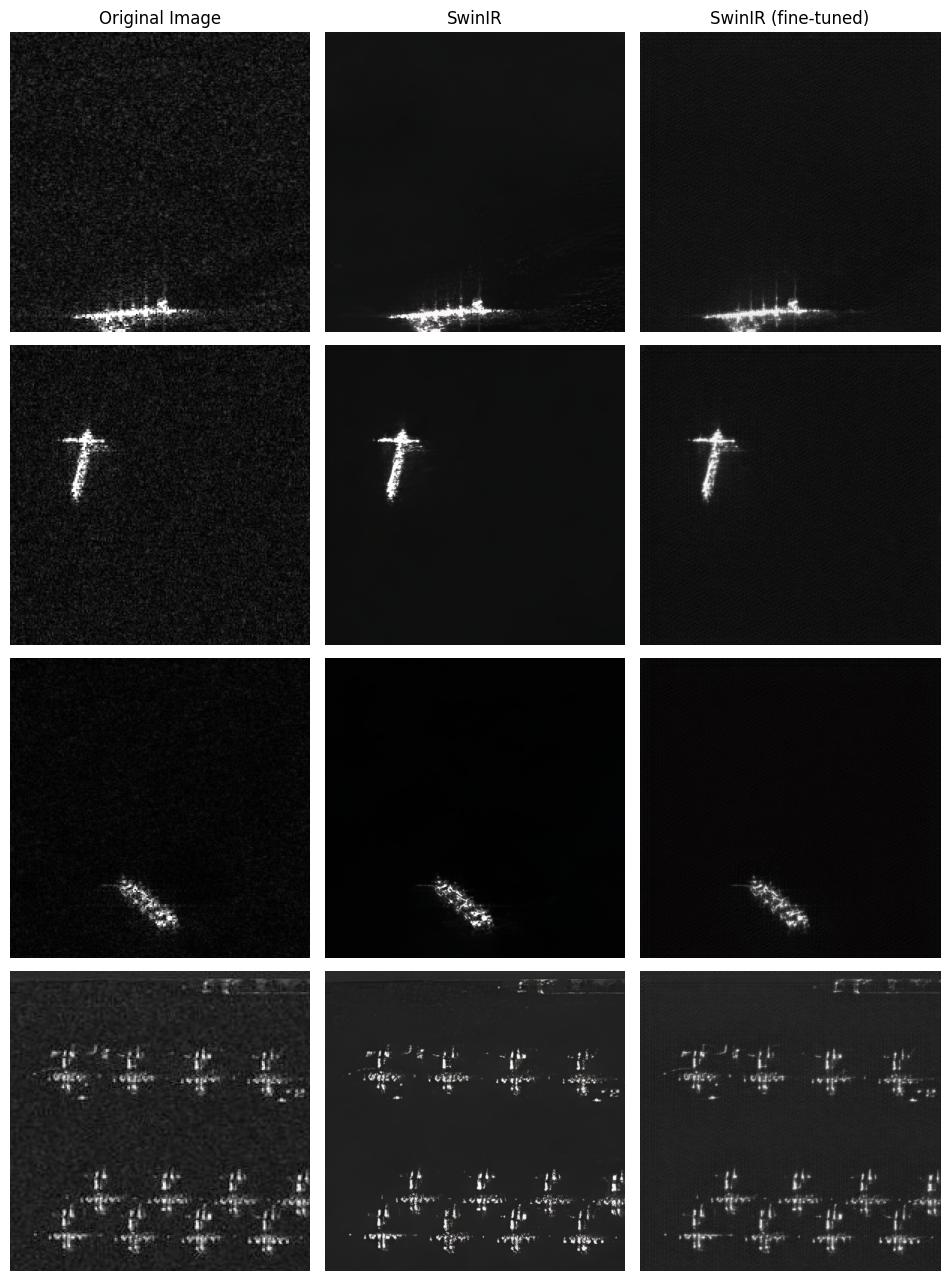

In [35]:
original_img_dir = os.path.join(root_dir, "sr_testing", "low_res_images")
results_dir = os.path.join(root_dir, "sr_testing", "results")

img_idxs = ["0", "2", "4", "15"]
num_cols = 3
num_images = len(img_idxs)

fig, axs = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(12,18), gridspec_kw={"wspace": 0.05, "hspace": -0.30})
axs[0, 0].axis("off")
axs[0, 0].set_title("Original Image")
col_titles = ["Original Image", "SwinIR", "SwinIR (fine-tuned)"]
for col, title in zip(range(num_cols), col_titles):
    axs[0, col].set_title(title)
    for row, img_idx in enumerate(img_idxs):
        axs[row, col].axis("off")
        if col == 0:
            original_img_path = os.path.join(original_img_dir, "img_idx" + img_idx + ".png")
            im = mpimg.imread(original_img_path)
            axs[row, col].imshow(im)
        elif col == 1:
            #swin_ir_medium_img_path = os.path.join(results_dir, "swin_ir_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            swin_ir_medium_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_real_sr_x4", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_img_path)
            axs[row, col].imshow(im)
        elif col == 2:
            swin_ir_medium_finetuned_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_x4_finetuned", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_finetuned_img_path)
            axs[row, col].imshow(im)
plt.axis('off')
fig_save_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "finetuning_results_fig.jpg")
plt.savefig(fig_save_path, dpi=1000)
plt.show()

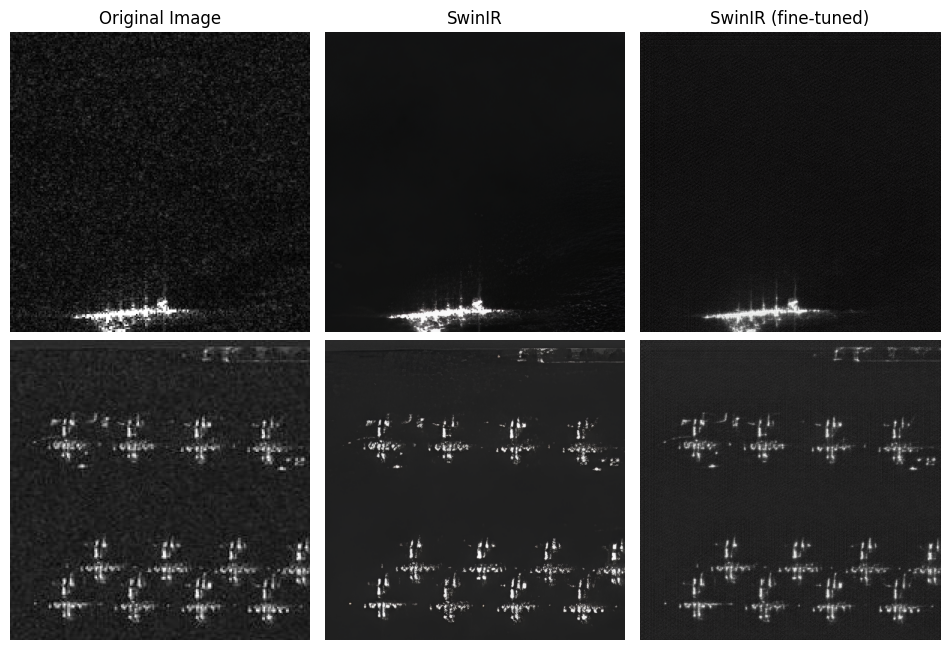

In [48]:
original_img_dir = os.path.join(root_dir, "sr_testing", "low_res_images")
results_dir = os.path.join(root_dir, "sr_testing", "results")

img_idxs = ["0", "15"]
num_cols = 3
num_images = len(img_idxs)

fig, axs = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(12,12), gridspec_kw={"wspace": 0.05, "hspace": -0.50})
axs[0, 0].axis("off")
axs[0, 0].set_title("Original Image")
col_titles = ["Original Image", "SwinIR", "SwinIR (fine-tuned)"]
for col, title in zip(range(num_cols), col_titles):
    axs[0, col].set_title(title)
    for row, img_idx in enumerate(img_idxs):
        axs[row, col].axis("off")
        if col == 0:
            original_img_path = os.path.join(original_img_dir, "img_idx" + img_idx + ".png")
            im = mpimg.imread(original_img_path)
            axs[row, col].imshow(im)
        elif col == 1:
            #swin_ir_medium_img_path = os.path.join(results_dir, "swin_ir_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            swin_ir_medium_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_real_sr_x4", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_img_path)
            axs[row, col].imshow(im)
        elif col == 2:
            swin_ir_medium_finetuned_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_x4_finetuned", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_finetuned_img_path)
            axs[row, col].imshow(im)
plt.axis('off')
fig_save_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "finetuning_results_fig_small.jpg")
plt.savefig(fig_save_path, dpi=1000)
plt.show()

### Create super resolved image for poster

In [25]:
from ultralytics import YOLO
import os, subprocess
from PIL import Image

In [22]:
dataset_path = os.path.join("/Users", "alexm", "Senior-Design", "datasets", "HRSID", "yolo")
test_patch_img_path = os.path.join(dataset_path, "test", "images", "P0008_600_1400_8400_9200_7_7319.png")
root_dir = os.path.join("/Users", "alexm", "Senior-Design")

In [18]:
# Get predictions from YOLO model 
model_path = os.path.join("/Users", "alexm", "Senior-Design", "runs", "detect", "hrsid_detection14", "weights", "best.pt")
model = YOLO(model_path)
results = model([test_patch_img_path])
pred_box = results[0].boxes.xyxy[0]


0: 224x224 2 ships, 34.0ms
Speed: 0.6ms preprocess, 34.0ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)


In [23]:
# Create super resolved full image
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "1500_G.pth")
save_path = os.path.join(root_dir, "poster_image")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", os.path.join(root_dir, "poster_image"),
     "--scale", "4",
     "--training_patch_size", "64",
     "--save_dir", save_path],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/1500_G.pth
Testing 0 P0008_600_1400_8400_9200_7_7319



In [31]:
full_super_img = Image.open(os.path.join(root_dir, "poster_image", "P0008_600_1400_8400_9200_7_7319_SwinIR.png"))
cropped_super_img = full_super_img.crop((int(pred_box[0] * 4), int(pred_box[1] * 4), int(pred_box[2] * 4), int(pred_box[3] * 4)))
cropped_super_img.save(os.path.join(root_dir, "poster_image", "P0008_600_1400_8400_9200_7_7319_SwinIR_cropped.png"))

## Compute PSNR for high-res test images with pre-trained and fine-tuned models

In [2]:
import os, glob, random, math, sys, pathlib, importlib
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
from basicsr.archs.rrdbnet_arch import RRDBNet 

In [3]:
# Use functions from KAIR github

KAIR = pathlib.Path(os.path.join("/Users", "alexm", "Senior-Design", "KAIR")).resolve()
sys.path.insert(0, KAIR.as_posix())
importlib.invalidate_caches()

from utils import utils_image as util
from utils.utils_blindsr import degradation_bsrgan
from utils.utils_image import calculate_psnr
from models.network_swinir import SwinIR
def load_model(model_path, device):

    weight_path = Path(model_path)
    name = weight_path.name

    if "RealESRGAN_x4plus" in name:
        model = RRDBNet(
            num_in_ch   = 3,
            num_out_ch  = 3,
            num_feat    = 64,
            num_block   = 23,
            num_grow_ch = 32,
            scale       = 4
        )
        ckpt = torch.load(weight_path, map_location=device)
        sd = ckpt.get('params') or ckpt.get('params_ema') or ckpt
    else:
        ckpt = torch.load(model_path, map_location="cpu")
        if isinstance(ckpt, dict) and ("params" in ckpt or "params_ema" in ckpt):
            sd = ckpt.get("params", ckpt.get("params_ema"))
        else:
            sd = ckpt

        embed_dim = sd["conv_first.weight"].shape[0]
        #print(embed_dim)

        if embed_dim == 240:
            model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                                img_range=1., depths=[6, 6, 6, 6, 6, 6, 6, 6, 6], embed_dim=embed_dim, num_heads=[8, 8, 8, 8, 8, 8, 8, 8, 8],
                                mlp_ratio=2, upsampler='nearest+conv', resi_connection='3conv')
        elif embed_dim == 180:
            model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8,
                                img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=embed_dim, num_heads=[6, 6, 6, 6, 6, 6],
                                mlp_ratio=2, upsampler='nearest+conv', resi_connection='1conv')
        else:
            print("Model not supported!")
        #param_key_g = 'params' if 'params' in torch.load(weight_path, map_location=device) else 'params_ema'
        loaded_model = torch.load(model_path)
        if 'params' in loaded_model:
            sd = loaded_model['params']
        elif 'params_ema' in loaded_model:
            sd = loaded_model['params_ema']
        else:
            sd = loaded_model
    model.load_state_dict(sd, strict=True)
    #model.load_state_dict(torch.load(weight_path, map_location=device)[param_key_g], strict=True)
    model.eval().to(device)
    return model

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
high_res_img_path = os.path.join("/Users", "alexm", "Senior-Design", "umbra_ship_detection_images", "ship_patches_high_res_test")
esrgan_model_path = os.path.join("/Users", "alexm", "Senior-Design", "sr_models", "RealESRGAN_x4plus.pth")
pretrained_model_path = os.path.join("/Users", "alexm", "Senior-Design", "sr_models", "003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
pretrained_large_model_path = os.path.join("/Users", "alexm", "Senior-Design", "sr_models", "003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth")
finetuned_model_path = os.path.join("/Users", "alexm", "Senior-Design", "sr_models", "1500_G.pth")

In [12]:
# Loop through high-res test images, degrade, get model predictions, compute psnr

device = torch.device('cpu')
esrgan_model = load_model(esrgan_model_path,  torch.device('cpu'))
pretrained_model = load_model(pretrained_model_path, device)
pretrained_large_model = load_model(pretrained_large_model_path, device)
finetuned_model = load_model(finetuned_model_path, device)

rng_state = random.getstate()
hr_files = sorted(glob.glob(os.path.join(high_res_img_path, '*')))


esrgan_psnr_list = []
pretrained_psnr_list = []
pretrained_large_psnr_list = []
finetuned_psnr_list = []

for f in tqdm(hr_files, desc='processing'):
    hr_uint = util.imread_uint(f, n_channels=3)
    hr = util.uint2single(hr_uint)  
    try:
        img_L, img_H = degradation_bsrgan(hr, sf=4)
        lq_uint  = util.single2uint(img_L) 
        lq_t = util.uint2tensor4(lq_uint).to(device)  
        with torch.no_grad():
            esrgan_sr_t = esrgan_model(lq_t)
            pretrained_sr_t = pretrained_model(lq_t)
            pretrained_large_sr_t = pretrained_large_model(lq_t)
            finetuned_sr_t = finetuned_model(lq_t)

        esrgan_sr = util.tensor2uint(esrgan_sr_t)   
        pretrained_sr = util.tensor2uint(pretrained_sr_t)   
        pretrained_large_sr = util.tensor2uint(pretrained_large_sr_t)   
        finetuned_sr = util.tensor2uint(finetuned_sr_t)   

        esrgan_psnr_val = calculate_psnr(esrgan_sr, img_H)
        pretrained_psnr_val = calculate_psnr(pretrained_sr, img_H)
        pretrained_large_psnr_val = calculate_psnr(pretrained_large_sr, img_H)
        finetuned_psnr_val = calculate_psnr(finetuned_sr, img_H)

        esrgan_psnr_list.append(esrgan_psnr_val)
        pretrained_psnr_list.append(pretrained_psnr_val)
        pretrained_large_psnr_list.append(pretrained_large_psnr_val)
        finetuned_psnr_list.append(finetuned_psnr_val)

        print(f'{os.path.basename(f):30s}  ESRGAN PSNR = {esrgan_psnr_val:5.2f} dB')
        print(f'{os.path.basename(f):30s}  Pretrained PSNR = {pretrained_psnr_val:5.2f} dB')
        print(f'{os.path.basename(f):30s}  Pretrained (large) PSNR = {pretrained_large_psnr_val:5.2f} dB')
        print(f'{os.path.basename(f):30s}  Finetuned PSNR = {finetuned_psnr_val:5.2f} dB')
    except:
        pass

print(f'ESRGAN: Median PSNR over {len(esrgan_psnr_list)} images: {np.median(esrgan_psnr_list):5.2f} dB')
print(f'Pretrained: Median PSNR over {len(pretrained_psnr_list)} images: {np.median(pretrained_psnr_list):5.2f} dB')
print(f'Pretrained (large): Median PSNR over {len(pretrained_large_psnr_list)} images: {np.median(pretrained_large_psnr_list):5.2f} dB')
print(f'Fine-tunedp: Median PSNR over {len(finetuned_psnr_list)} images: {np.median(finetuned_psnr_list):5.2f} dB')
    

processing:   2%|▏         | 1/52 [00:03<02:34,  3.04s/it]

2023-01-23-02-43-34_UMBRA-04_2.jpg  ESRGAN PSNR = 14.29 dB
2023-01-23-02-43-34_UMBRA-04_2.jpg  Pretrained PSNR = 15.33 dB
2023-01-23-02-43-34_UMBRA-04_2.jpg  Pretrained (large) PSNR = 15.38 dB
2023-01-23-02-43-34_UMBRA-04_2.jpg  Finetuned PSNR = 14.32 dB


processing:   4%|▍         | 2/52 [00:11<05:08,  6.18s/it]

2023-01-27-13-02-56_UMBRA-04_288.jpg  ESRGAN PSNR = 16.92 dB
2023-01-27-13-02-56_UMBRA-04_288.jpg  Pretrained PSNR = 16.25 dB
2023-01-27-13-02-56_UMBRA-04_288.jpg  Pretrained (large) PSNR = 16.45 dB
2023-01-27-13-02-56_UMBRA-04_288.jpg  Finetuned PSNR = 16.45 dB


processing:   6%|▌         | 3/52 [00:14<03:53,  4.77s/it]

2023-01-27-13-02-56_UMBRA-04_294.jpg  ESRGAN PSNR = 10.62 dB
2023-01-27-13-02-56_UMBRA-04_294.jpg  Pretrained PSNR = 10.63 dB
2023-01-27-13-02-56_UMBRA-04_294.jpg  Pretrained (large) PSNR = 11.49 dB
2023-01-27-13-02-56_UMBRA-04_294.jpg  Finetuned PSNR = 10.71 dB


processing:   8%|▊         | 4/52 [00:19<03:50,  4.81s/it]

2023-02-02-02-44-09_UMBRA-05_15.jpg  ESRGAN PSNR = 19.03 dB
2023-02-02-02-44-09_UMBRA-05_15.jpg  Pretrained PSNR = 18.87 dB
2023-02-02-02-44-09_UMBRA-05_15.jpg  Pretrained (large) PSNR = 19.00 dB
2023-02-02-02-44-09_UMBRA-05_15.jpg  Finetuned PSNR = 19.22 dB


processing:  10%|▉         | 5/52 [00:22<03:12,  4.09s/it]

2023-02-03-15-18-12_UMBRA-05_238.jpg  ESRGAN PSNR = 20.04 dB
2023-02-03-15-18-12_UMBRA-05_238.jpg  Pretrained PSNR = 18.20 dB
2023-02-03-15-18-12_UMBRA-05_238.jpg  Pretrained (large) PSNR = 18.36 dB
2023-02-03-15-18-12_UMBRA-05_238.jpg  Finetuned PSNR = 19.68 dB


processing:  12%|█▏        | 6/52 [00:25<02:51,  3.73s/it]

2023-02-11-02-01-10_UMBRA-04_206.jpg  ESRGAN PSNR = 13.59 dB
2023-02-11-02-01-10_UMBRA-04_206.jpg  Pretrained PSNR = 16.41 dB
2023-02-11-02-01-10_UMBRA-04_206.jpg  Pretrained (large) PSNR = 15.68 dB
2023-02-11-02-01-10_UMBRA-04_206.jpg  Finetuned PSNR = 13.85 dB


processing:  13%|█▎        | 7/52 [00:28<02:41,  3.59s/it]

2023-02-13-02-05-09_UMBRA-04_159.jpg  ESRGAN PSNR = 19.52 dB
2023-02-13-02-05-09_UMBRA-04_159.jpg  Pretrained PSNR = 19.71 dB
2023-02-13-02-05-09_UMBRA-04_159.jpg  Pretrained (large) PSNR = 20.02 dB
2023-02-13-02-05-09_UMBRA-04_159.jpg  Finetuned PSNR = 20.67 dB


processing:  17%|█▋        | 9/52 [00:31<01:51,  2.58s/it]

2023-02-26-02-16-26_UMBRA-05_251.jpg  ESRGAN PSNR = 19.32 dB
2023-02-26-02-16-26_UMBRA-05_251.jpg  Pretrained PSNR = 19.03 dB
2023-02-26-02-16-26_UMBRA-05_251.jpg  Pretrained (large) PSNR = 19.59 dB
2023-02-26-02-16-26_UMBRA-05_251.jpg  Finetuned PSNR = 19.03 dB


processing:  19%|█▉        | 10/52 [00:35<01:59,  2.84s/it]

2023-02-26-12-59-08_UMBRA-04_299.jpg  ESRGAN PSNR = 18.75 dB
2023-02-26-12-59-08_UMBRA-04_299.jpg  Pretrained PSNR = 18.83 dB
2023-02-26-12-59-08_UMBRA-04_299.jpg  Pretrained (large) PSNR = 18.89 dB
2023-02-26-12-59-08_UMBRA-04_299.jpg  Finetuned PSNR = 19.20 dB


processing:  21%|██        | 11/52 [00:38<02:03,  3.00s/it]

2023-02-26-12-59-08_UMBRA-04_303.jpg  ESRGAN PSNR = 17.85 dB
2023-02-26-12-59-08_UMBRA-04_303.jpg  Pretrained PSNR = 17.70 dB
2023-02-26-12-59-08_UMBRA-04_303.jpg  Pretrained (large) PSNR = 17.64 dB
2023-02-26-12-59-08_UMBRA-04_303.jpg  Finetuned PSNR = 17.59 dB


processing:  23%|██▎       | 12/52 [00:43<02:16,  3.40s/it]

2023-02-26-12-59-08_UMBRA-04_308.jpg  ESRGAN PSNR = 17.75 dB
2023-02-26-12-59-08_UMBRA-04_308.jpg  Pretrained PSNR = 17.59 dB
2023-02-26-12-59-08_UMBRA-04_308.jpg  Pretrained (large) PSNR = 17.58 dB
2023-02-26-12-59-08_UMBRA-04_308.jpg  Finetuned PSNR = 17.74 dB


processing:  25%|██▌       | 13/52 [00:45<02:07,  3.26s/it]

2023-02-26-12-59-08_UMBRA-04_312.jpg  ESRGAN PSNR = 18.03 dB
2023-02-26-12-59-08_UMBRA-04_312.jpg  Pretrained PSNR = 17.97 dB
2023-02-26-12-59-08_UMBRA-04_312.jpg  Pretrained (large) PSNR = 18.09 dB
2023-02-26-12-59-08_UMBRA-04_312.jpg  Finetuned PSNR = 18.09 dB


processing:  27%|██▋       | 14/52 [00:49<02:02,  3.23s/it]

2023-03-06-02-08-59_UMBRA-04_25.jpg  ESRGAN PSNR = 16.95 dB
2023-03-06-02-08-59_UMBRA-04_25.jpg  Pretrained PSNR = 17.15 dB
2023-03-06-02-08-59_UMBRA-04_25.jpg  Pretrained (large) PSNR = 17.25 dB
2023-03-06-02-08-59_UMBRA-04_25.jpg  Finetuned PSNR = 17.08 dB


processing:  29%|██▉       | 15/52 [00:53<02:10,  3.53s/it]

2023-03-07-01-32-07_UMBRA-05_257.jpg  ESRGAN PSNR = 11.81 dB
2023-03-07-01-32-07_UMBRA-05_257.jpg  Pretrained PSNR = 12.19 dB
2023-03-07-01-32-07_UMBRA-05_257.jpg  Pretrained (large) PSNR = 11.99 dB
2023-03-07-01-32-07_UMBRA-05_257.jpg  Finetuned PSNR = 12.07 dB


processing:  31%|███       | 16/52 [00:56<02:03,  3.42s/it]

2023-05-19-20-52-27_UMBRA-04_212.jpg  ESRGAN PSNR = 11.28 dB
2023-05-19-20-52-27_UMBRA-04_212.jpg  Pretrained PSNR = 12.23 dB
2023-05-19-20-52-27_UMBRA-04_212.jpg  Pretrained (large) PSNR = 12.54 dB
2023-05-19-20-52-27_UMBRA-04_212.jpg  Finetuned PSNR = 11.24 dB


processing:  33%|███▎      | 17/52 [00:59<01:57,  3.34s/it]

2023-05-26-02-28-49_UMBRA-05_184.jpg  ESRGAN PSNR = 12.84 dB
2023-05-26-02-28-49_UMBRA-05_184.jpg  Pretrained PSNR = 12.93 dB
2023-05-26-02-28-49_UMBRA-05_184.jpg  Pretrained (large) PSNR = 12.94 dB
2023-05-26-02-28-49_UMBRA-05_184.jpg  Finetuned PSNR = 12.91 dB


processing:  35%|███▍      | 18/52 [01:02<01:48,  3.19s/it]

2023-06-03-15-53-36_UMBRA-06_138.jpg  ESRGAN PSNR =  7.95 dB
2023-06-03-15-53-36_UMBRA-06_138.jpg  Pretrained PSNR =  7.80 dB
2023-06-03-15-53-36_UMBRA-06_138.jpg  Pretrained (large) PSNR =  7.77 dB
2023-06-03-15-53-36_UMBRA-06_138.jpg  Finetuned PSNR =  7.75 dB


processing:  37%|███▋      | 19/52 [01:08<02:08,  3.89s/it]

2023-06-03-15-53-36_UMBRA-06_142.jpg  ESRGAN PSNR = 10.16 dB
2023-06-03-15-53-36_UMBRA-06_142.jpg  Pretrained PSNR = 10.59 dB
2023-06-03-15-53-36_UMBRA-06_142.jpg  Pretrained (large) PSNR = 10.54 dB
2023-06-03-15-53-36_UMBRA-06_142.jpg  Finetuned PSNR = 10.81 dB


processing:  38%|███▊      | 20/52 [01:11<01:57,  3.68s/it]

2023-07-02-15-38-57_UMBRA-04_276.jpg  ESRGAN PSNR = 15.84 dB
2023-07-02-15-38-57_UMBRA-04_276.jpg  Pretrained PSNR = 15.15 dB
2023-07-02-15-38-57_UMBRA-04_276.jpg  Pretrained (large) PSNR = 15.45 dB
2023-07-02-15-38-57_UMBRA-04_276.jpg  Finetuned PSNR = 15.26 dB


processing:  40%|████      | 21/52 [01:15<01:58,  3.84s/it]

2023-08-27-03-42-51_UMBRA-05_202.jpg  ESRGAN PSNR = 10.21 dB
2023-08-27-03-42-51_UMBRA-05_202.jpg  Pretrained PSNR = 10.68 dB
2023-08-27-03-42-51_UMBRA-05_202.jpg  Pretrained (large) PSNR = 10.52 dB
2023-08-27-03-42-51_UMBRA-05_202.jpg  Finetuned PSNR = 10.32 dB


processing:  42%|████▏     | 22/52 [01:18<01:49,  3.66s/it]

2023-09-01-05-43-00_UMBRA-05_132.jpg  ESRGAN PSNR = 10.40 dB
2023-09-01-05-43-00_UMBRA-05_132.jpg  Pretrained PSNR = 10.64 dB
2023-09-01-05-43-00_UMBRA-05_132.jpg  Pretrained (large) PSNR = 10.54 dB
2023-09-01-05-43-00_UMBRA-05_132.jpg  Finetuned PSNR = 10.81 dB


processing:  44%|████▍     | 23/52 [01:21<01:40,  3.47s/it]

2023-09-05-01-38-10_UMBRA-04_160.jpg  ESRGAN PSNR = 15.75 dB
2023-09-05-01-38-10_UMBRA-04_160.jpg  Pretrained PSNR = 15.74 dB
2023-09-05-01-38-10_UMBRA-04_160.jpg  Pretrained (large) PSNR = 16.08 dB
2023-09-05-01-38-10_UMBRA-04_160.jpg  Finetuned PSNR = 15.68 dB


processing:  46%|████▌     | 24/52 [01:24<01:31,  3.27s/it]

2023-10-01-12-37-00_UMBRA-05_146.jpg  ESRGAN PSNR = 17.03 dB
2023-10-01-12-37-00_UMBRA-05_146.jpg  Pretrained PSNR = 17.14 dB
2023-10-01-12-37-00_UMBRA-05_146.jpg  Pretrained (large) PSNR = 16.80 dB
2023-10-01-12-37-00_UMBRA-05_146.jpg  Finetuned PSNR = 16.38 dB


processing:  48%|████▊     | 25/52 [01:27<01:23,  3.11s/it]

2023-10-28-09-51-46_UMBRA-05_130.jpg  ESRGAN PSNR = 10.61 dB
2023-10-28-09-51-46_UMBRA-05_130.jpg  Pretrained PSNR = 10.70 dB
2023-10-28-09-51-46_UMBRA-05_130.jpg  Pretrained (large) PSNR = 10.91 dB
2023-10-28-09-51-46_UMBRA-05_130.jpg  Finetuned PSNR = 10.54 dB


processing:  50%|█████     | 26/52 [01:30<01:26,  3.31s/it]

2023-11-07-16-40-42_UMBRA-05_104.jpg  ESRGAN PSNR = 13.47 dB
2023-11-07-16-40-42_UMBRA-05_104.jpg  Pretrained PSNR = 13.33 dB
2023-11-07-16-40-42_UMBRA-05_104.jpg  Pretrained (large) PSNR = 12.90 dB
2023-11-07-16-40-42_UMBRA-05_104.jpg  Finetuned PSNR = 13.28 dB


processing:  52%|█████▏    | 27/52 [01:34<01:25,  3.41s/it]

2023-11-07-16-40-42_UMBRA-05_108.jpg  ESRGAN PSNR = 12.72 dB
2023-11-07-16-40-42_UMBRA-05_108.jpg  Pretrained PSNR = 12.79 dB
2023-11-07-16-40-42_UMBRA-05_108.jpg  Pretrained (large) PSNR = 12.75 dB
2023-11-07-16-40-42_UMBRA-05_108.jpg  Finetuned PSNR = 12.75 dB


processing:  54%|█████▍    | 28/52 [01:37<01:20,  3.34s/it]

2023-11-07-16-40-42_UMBRA-05_69.jpg  ESRGAN PSNR = 41.97 dB
2023-11-07-16-40-42_UMBRA-05_69.jpg  Pretrained PSNR = 27.03 dB
2023-11-07-16-40-42_UMBRA-05_69.jpg  Pretrained (large) PSNR = 27.45 dB
2023-11-07-16-40-42_UMBRA-05_69.jpg  Finetuned PSNR = 28.97 dB


processing:  56%|█████▌    | 29/52 [01:40<01:12,  3.16s/it]

2023-11-07-16-40-42_UMBRA-05_85.jpg  ESRGAN PSNR = 17.00 dB
2023-11-07-16-40-42_UMBRA-05_85.jpg  Pretrained PSNR = 16.62 dB
2023-11-07-16-40-42_UMBRA-05_85.jpg  Pretrained (large) PSNR = 16.61 dB
2023-11-07-16-40-42_UMBRA-05_85.jpg  Finetuned PSNR = 16.59 dB


processing:  58%|█████▊    | 30/52 [01:45<01:21,  3.70s/it]

2023-11-07-16-40-42_UMBRA-05_93.jpg  ESRGAN PSNR = 36.77 dB
2023-11-07-16-40-42_UMBRA-05_93.jpg  Pretrained PSNR = 27.21 dB
2023-11-07-16-40-42_UMBRA-05_93.jpg  Pretrained (large) PSNR = 27.06 dB
2023-11-07-16-40-42_UMBRA-05_93.jpg  Finetuned PSNR = 27.39 dB


processing:  60%|█████▉    | 31/52 [01:48<01:14,  3.54s/it]

2023-11-07-16-40-42_UMBRA-05_96.jpg  ESRGAN PSNR = 14.28 dB
2023-11-07-16-40-42_UMBRA-05_96.jpg  Pretrained PSNR = 14.18 dB
2023-11-07-16-40-42_UMBRA-05_96.jpg  Pretrained (large) PSNR = 14.16 dB
2023-11-07-16-40-42_UMBRA-05_96.jpg  Finetuned PSNR = 14.13 dB


processing:  62%|██████▏   | 32/52 [01:53<01:20,  4.00s/it]

2023-11-07-16-40-42_UMBRA-05_97.jpg  ESRGAN PSNR = 14.06 dB
2023-11-07-16-40-42_UMBRA-05_97.jpg  Pretrained PSNR = 14.14 dB
2023-11-07-16-40-42_UMBRA-05_97.jpg  Pretrained (large) PSNR = 13.99 dB
2023-11-07-16-40-42_UMBRA-05_97.jpg  Finetuned PSNR = 14.02 dB


processing:  65%|██████▌   | 34/52 [01:57<00:55,  3.08s/it]

2023-11-15-12-48-16_UMBRA-04_320.jpg  ESRGAN PSNR = 13.37 dB
2023-11-15-12-48-16_UMBRA-04_320.jpg  Pretrained PSNR = 13.97 dB
2023-11-15-12-48-16_UMBRA-04_320.jpg  Pretrained (large) PSNR = 13.38 dB
2023-11-15-12-48-16_UMBRA-04_320.jpg  Finetuned PSNR = 13.30 dB


processing:  67%|██████▋   | 35/52 [02:04<01:06,  3.94s/it]

2023-12-01-01-52-43_UMBRA-06_343.jpg  ESRGAN PSNR = 18.53 dB
2023-12-01-01-52-43_UMBRA-06_343.jpg  Pretrained PSNR = 18.08 dB
2023-12-01-01-52-43_UMBRA-06_343.jpg  Pretrained (large) PSNR = 18.09 dB
2023-12-01-01-52-43_UMBRA-06_343.jpg  Finetuned PSNR = 18.20 dB


processing:  69%|██████▉   | 36/52 [02:07<01:00,  3.77s/it]

2023-12-01-01-52-43_UMBRA-06_349.jpg  ESRGAN PSNR =  8.80 dB
2023-12-01-01-52-43_UMBRA-06_349.jpg  Pretrained PSNR =  9.50 dB
2023-12-01-01-52-43_UMBRA-06_349.jpg  Pretrained (large) PSNR =  9.19 dB
2023-12-01-01-52-43_UMBRA-06_349.jpg  Finetuned PSNR =  9.43 dB


processing:  71%|███████   | 37/52 [02:11<00:57,  3.84s/it]

2023-12-01-01-52-43_UMBRA-06_352.jpg  ESRGAN PSNR = 14.89 dB
2023-12-01-01-52-43_UMBRA-06_352.jpg  Pretrained PSNR = 14.66 dB
2023-12-01-01-52-43_UMBRA-06_352.jpg  Pretrained (large) PSNR = 14.69 dB
2023-12-01-01-52-43_UMBRA-06_352.jpg  Finetuned PSNR = 14.66 dB


processing:  73%|███████▎  | 38/52 [02:14<00:51,  3.66s/it]

2023-12-02-09-49-19_UMBRA-06_126.jpg  ESRGAN PSNR = 17.75 dB
2023-12-02-09-49-19_UMBRA-06_126.jpg  Pretrained PSNR = 17.47 dB
2023-12-02-09-49-19_UMBRA-06_126.jpg  Pretrained (large) PSNR = 17.42 dB
2023-12-02-09-49-19_UMBRA-06_126.jpg  Finetuned PSNR = 17.91 dB


processing:  75%|███████▌  | 39/52 [02:19<00:52,  4.03s/it]

2023-12-15-12-47-22_UMBRA-04_147.jpg  ESRGAN PSNR = 14.21 dB
2023-12-15-12-47-22_UMBRA-04_147.jpg  Pretrained PSNR = 14.35 dB
2023-12-15-12-47-22_UMBRA-04_147.jpg  Pretrained (large) PSNR = 14.14 dB
2023-12-15-12-47-22_UMBRA-04_147.jpg  Finetuned PSNR = 14.13 dB


processing:  77%|███████▋  | 40/52 [02:22<00:44,  3.74s/it]

2023-12-15-12-47-22_UMBRA-04_152.jpg  ESRGAN PSNR = 16.16 dB
2023-12-15-12-47-22_UMBRA-04_152.jpg  Pretrained PSNR = 16.91 dB
2023-12-15-12-47-22_UMBRA-04_152.jpg  Pretrained (large) PSNR = 16.67 dB
2023-12-15-12-47-22_UMBRA-04_152.jpg  Finetuned PSNR = 16.20 dB


processing:  79%|███████▉  | 41/52 [02:26<00:41,  3.75s/it]

2023-12-20-01-02-38_UMBRA-05_37.jpg  ESRGAN PSNR = 11.43 dB
2023-12-20-01-02-38_UMBRA-05_37.jpg  Pretrained PSNR = 11.22 dB
2023-12-20-01-02-38_UMBRA-05_37.jpg  Pretrained (large) PSNR = 11.14 dB
2023-12-20-01-02-38_UMBRA-05_37.jpg  Finetuned PSNR = 11.51 dB


processing:  81%|████████  | 42/52 [02:29<00:35,  3.50s/it]

2023-12-20-01-02-38_UMBRA-05_39.jpg  ESRGAN PSNR = 10.46 dB
2023-12-20-01-02-38_UMBRA-05_39.jpg  Pretrained PSNR = 10.48 dB
2023-12-20-01-02-38_UMBRA-05_39.jpg  Pretrained (large) PSNR = 10.48 dB
2023-12-20-01-02-38_UMBRA-05_39.jpg  Finetuned PSNR = 10.84 dB


processing:  83%|████████▎ | 43/52 [02:33<00:32,  3.60s/it]

2023-12-20-01-02-38_UMBRA-05_45.jpg  ESRGAN PSNR = 13.34 dB
2023-12-20-01-02-38_UMBRA-05_45.jpg  Pretrained PSNR = 12.91 dB
2023-12-20-01-02-38_UMBRA-05_45.jpg  Pretrained (large) PSNR = 13.08 dB
2023-12-20-01-02-38_UMBRA-05_45.jpg  Finetuned PSNR = 13.00 dB


processing:  85%|████████▍ | 44/52 [02:36<00:28,  3.54s/it]

2023-12-20-01-02-38_UMBRA-05_56.jpg  ESRGAN PSNR = 12.50 dB
2023-12-20-01-02-38_UMBRA-05_56.jpg  Pretrained PSNR = 12.30 dB
2023-12-20-01-02-38_UMBRA-05_56.jpg  Pretrained (large) PSNR = 12.35 dB
2023-12-20-01-02-38_UMBRA-05_56.jpg  Finetuned PSNR = 12.56 dB


processing:  87%|████████▋ | 45/52 [02:39<00:23,  3.37s/it]

2023-12-28-11-34-04_UMBRA-04_261.jpg  ESRGAN PSNR = 14.49 dB
2023-12-28-11-34-04_UMBRA-04_261.jpg  Pretrained PSNR = 14.52 dB
2023-12-28-11-34-04_UMBRA-04_261.jpg  Pretrained (large) PSNR = 14.45 dB
2023-12-28-11-34-04_UMBRA-04_261.jpg  Finetuned PSNR = 14.47 dB


processing:  88%|████████▊ | 46/52 [02:42<00:19,  3.31s/it]

2023-12-28-11-34-04_UMBRA-04_265.jpg  ESRGAN PSNR = 12.91 dB
2023-12-28-11-34-04_UMBRA-04_265.jpg  Pretrained PSNR = 12.96 dB
2023-12-28-11-34-04_UMBRA-04_265.jpg  Pretrained (large) PSNR = 12.92 dB
2023-12-28-11-34-04_UMBRA-04_265.jpg  Finetuned PSNR = 12.96 dB


processing:  90%|█████████ | 47/52 [02:45<00:16,  3.25s/it]

2023-12-30-02-56-59_UMBRA-04_29.jpg  ESRGAN PSNR = 12.42 dB
2023-12-30-02-56-59_UMBRA-04_29.jpg  Pretrained PSNR = 12.06 dB
2023-12-30-02-56-59_UMBRA-04_29.jpg  Pretrained (large) PSNR = 11.90 dB
2023-12-30-02-56-59_UMBRA-04_29.jpg  Finetuned PSNR = 12.19 dB


processing:  92%|█████████▏| 48/52 [02:49<00:12,  3.20s/it]

2023-12-30-02-56-59_UMBRA-04_31.jpg  ESRGAN PSNR = 14.84 dB
2023-12-30-02-56-59_UMBRA-04_31.jpg  Pretrained PSNR = 14.94 dB
2023-12-30-02-56-59_UMBRA-04_31.jpg  Pretrained (large) PSNR = 14.87 dB
2023-12-30-02-56-59_UMBRA-04_31.jpg  Finetuned PSNR = 14.75 dB


processing:  94%|█████████▍| 49/52 [02:52<00:09,  3.19s/it]

2024-01-02-03-12-35_UMBRA-06_334.jpg  ESRGAN PSNR =  8.89 dB
2024-01-02-03-12-35_UMBRA-06_334.jpg  Pretrained PSNR =  9.06 dB
2024-01-02-03-12-35_UMBRA-06_334.jpg  Pretrained (large) PSNR =  8.91 dB
2024-01-02-03-12-35_UMBRA-06_334.jpg  Finetuned PSNR =  9.28 dB


processing:  96%|█████████▌| 50/52 [02:55<00:06,  3.18s/it]

2024-03-28-03-28-57_UMBRA-08_60.jpg  ESRGAN PSNR = 15.40 dB
2024-03-28-03-28-57_UMBRA-08_60.jpg  Pretrained PSNR = 15.32 dB
2024-03-28-03-28-57_UMBRA-08_60.jpg  Pretrained (large) PSNR = 15.45 dB
2024-03-28-03-28-57_UMBRA-08_60.jpg  Finetuned PSNR = 15.18 dB


processing:  98%|█████████▊| 51/52 [03:02<00:04,  4.51s/it]

2024-03-31-16-42-51_UMBRA-06_10.jpg  ESRGAN PSNR = 16.97 dB
2024-03-31-16-42-51_UMBRA-06_10.jpg  Pretrained PSNR = 16.93 dB
2024-03-31-16-42-51_UMBRA-06_10.jpg  Pretrained (large) PSNR = 16.98 dB
2024-03-31-16-42-51_UMBRA-06_10.jpg  Finetuned PSNR = 16.82 dB


processing: 100%|██████████| 52/52 [03:08<00:00,  3.62s/it]

2024-03-31-16-42-51_UMBRA-06_11.jpg  ESRGAN PSNR = 18.04 dB
2024-03-31-16-42-51_UMBRA-06_11.jpg  Pretrained PSNR = 17.52 dB
2024-03-31-16-42-51_UMBRA-06_11.jpg  Pretrained (large) PSNR = 18.04 dB
2024-03-31-16-42-51_UMBRA-06_11.jpg  Finetuned PSNR = 17.60 dB
ESRGAN: Median PSNR over 50 images: 14.39 dB
Pretrained: Median PSNR over 50 images: 14.80 dB
Pretrained (large): Median PSNR over 50 images: 14.78 dB
Fine-tunedp: Median PSNR over 50 images: 14.39 dB
